In [ ]:
import os
import pandas as pd
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.optimizers import SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/labeled_data_with_no_replies_links.csv')
df.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932730 entries, 0 to 932729
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Tweet Id           932730 non-null  object
 1   sentiment          364712 non-null  object
 2   country            364711 non-null  object
 3   Datetime           932729 non-null  object
 4   Username           932727 non-null  object
 5   text               932728 non-null  object
 6   text_ett           932727 non-null  object
 7   pr_text            932727 non-null  object
 8   pr_text_swr        931850 non-null  object
 9   pr_text_swr_lemma  931850 non-null  object
dtypes: object(10)
memory usage: 71.2+ MB


#Data Preprocessing

#### Deduplicate tweets

In [ ]:
df = df.drop_duplicates(subset=['Tweet Id'], keep='first')

#### Lowercase

In [ ]:
df['text'] = df.Text.str.lower()
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Tweet Id,sentiment,country,Datetime,Username,text,text_ett,pr_text,pr_text_swr,pr_text_swr_lemma
0,1215249537834442753,NaN,NaN,2020-01-09 12:30:42,MackayIM,for those who take seriously a blatantly light...,for those who take seriously a blatantly light...,for those who take seriously blatantly lighthe...,take seriously blatantly lighthearted thread n...,take seriously blatantly lighthearted thread n...
1,1215076140412366848,NaN,NaN,2020-01-09 01:01:41,GlenwoodNate,the virus circulating in china now has been de...,the virus circulating in china now has been de...,the virus circulating in china now has been de...,virus circulating china described novel much l...,virus circulating china described novel much l...
2,1217191264858206209,NaN,NaN,2020-01-14 21:06:26,HelenBranswell,1. a thread on @who's update today on the case...,1. a thread on @who's update today on the case...,1 thread on update today on the case of novel ...,1 thread update today case novel infection det...,1 thread update today case novel infection det...
3,1217063853894307842,NaN,NaN,2020-01-14 12:40:09,BioMickWatson,dismayed that novel coronavirus has been calle...,dismayed that novel coronavirus has been calle...,dismayed that novel coronavirus has been calle...,dismayed novel called novel ncov,dismayed novel called novel ncov
4,1217806193185288193,NaN,NaN,2020-01-16 13:49:56,MackayIM,have we seen any cases of pneumonia or respira...,have we seen any cases of pneumonia or respira...,have we seen any cases of pneumonia or respira...,seen cases pneumonia respiratory illness assoc...,seen case pneumonia respiratory illness associ...


In [ ]:
df = df[(df.text.str.contains('covid'))|(df.text.str.contains('coronavirus'))] #to ensure tweets have a reference to covid and are not extrcaed due to just the username having reference to covid

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932727 entries, 0 to 932729
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Tweet Id           932727 non-null  object
 1   sentiment          364710 non-null  object
 2   country            364710 non-null  object
 3   Datetime           932727 non-null  object
 4   Username           932726 non-null  object
 5   text               932727 non-null  object
 6   text_ett           932727 non-null  object
 7   pr_text            932727 non-null  object
 8   pr_text_swr        931850 non-null  object
 9   pr_text_swr_lemma  931850 non-null  object
dtypes: object(10)
memory usage: 78.3+ MB


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932728 entries, 0 to 932727
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet Id   932728 non-null  object
 1   sentiment  364710 non-null  object
 2   country    364710 non-null  object
 3   Datetime   932728 non-null  object
 4   Text       932728 non-null  object
 5   Username   932727 non-null  object
 6   text       932728 non-null  object
dtypes: object(7)
memory usage: 49.8+ MB


In [ ]:
df_lab=df.dropna()   # Keep the data set containing Lables for further processing & model training 

In [ ]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364541 entries, 3217 to 932709
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Tweet Id           364541 non-null  object
 1   sentiment          364541 non-null  object
 2   country            364541 non-null  object
 3   Datetime           364541 non-null  object
 4   Username           364541 non-null  object
 5   text               364541 non-null  object
 6   text_ett           364541 non-null  object
 7   pr_text            364541 non-null  object
 8   pr_text_swr        364541 non-null  object
 9   pr_text_swr_lemma  364541 non-null  object
dtypes: object(10)
memory usage: 30.6+ MB


####Replace emojis with descriptions

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=dee954c3670cb39c989d6f4f51f146a9c1259d78c960b1d203e47e34b5cc7946
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
import emoji as ej

In [ ]:
def emoji_to_text(text):
    if type(text) != float:
        return (ej.demojize(text)).replace(":", " ").replace("_"," ")
    else:
        return text.replace(":", " ").replace("_"," ")

####Removal of URLs, usernames, hashtags

In [ ]:
def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    tweet = re.sub('#','',tweet)
    #emoj = re.compile("["
        #u"\U0001F600-\U0001F64F"  # emoticons
        #u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #u"\U0001F680-\U0001F6FF"  # transport & map symbols
        #u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #u"\U00002500-\U00002BEF"  # chinese char
        #u"\U00002702-\U000027B0"
        #u"\U00002702-\U000027B0"
        #u"\U000024C2-\U0001F251"
        #u"\U0001f926-\U0001f937"
        #u"\U00010000-\U0010ffff"
        #u"\u2640-\u2642" 
        #u"\u2600-\u2B55"
        #u"\u200d"
        #u"\u23cf"
        #u"\u23e9"
        #u"\u231a"
        #u"\ufe0f"  # dingbats
        #u"\u3030"
        #              "]+", re.UNICODE)
    #return re.sub(emoj, '', tweet)
    return tweet

####Remove multiple spaces

In [ ]:
def remove_mult_spaces(text): # remove multiple spaces
  return re.sub("\s\s+" , " ", text)

####Expand contractions

In [ ]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it’s":"it is","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are","what’s":"what is" ,"what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
# df['pr_text']=df['pr_text'].apply(lambda x:expand_contractions(x))

In [ ]:
def CleanFurther(Text):
  Text = re.sub(" \d+", " ", Text) # Remove Numbers 
  Text = re.sub(r'(?:^| )\w(?:$| )', ' ', Text).strip() # remove Single letters 
  Text = re.sub('[%s]' % re.escape("""!"#$%&'’()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', Text)  # remove punctuations
  Text = re.sub('\s+', ' ',Text) #remove Extra whitespaces
  return Text

#### Removal of stop words

In [ ]:
import string
# NLTK imports
import nltk
nltk.download('punkt')
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Removing few important words from default stop words  
for word in ['not','no','nor']:
  stop_words.remove(word)

In [ ]:
# Adding additional stop words  to stop words corpus 
for word in ['covid','covid19','corona','coronavirus','corona virus','amp','face','’']:
  stop_words.add(word)

#### Lemmatization

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

Processing Function

In [ ]:
def data_processing(df):
  # drop nulls
  new_df = df.dropna(subset=['Text'])
  # drop duplicates
  new_df = new_df.drop_duplicates(subset=['Tweet Id'], keep='first')
  new_df['text'] = new_df.Text.str.lower()
  new_df['text'] = new_df.text.apply(lambda x:remove_mult_spaces(x))
  new_df = new_df.drop(columns='Text')
  new_df = new_df[(new_df.text.str.contains('covid'))|(new_df.text.str.contains('coronavirus'))] #to ensure tweets have a reference to covid and are not extrcaed due to just the username having reference to covid
  new_df = new_df.reset_index(drop=True)
  new_df['text_ett'] = new_df['text'].apply(emoji_to_text)
  new_df['pr_text'] = new_df.text_ett.apply(lambda x:remove_usernames_links(x)).values
  new_df['pr_text']=new_df['pr_text'].apply(lambda x:expand_contractions(x))
  new_df['pr_text']=new_df['pr_text'].apply(lambda x:CleanFurther(x))
  new_df['pr_text_swr'] = new_df['pr_text'].apply(lambda x: ' '.join([str(w).strip('.') for w in word_tokenize(x) if not w in stop_words if not w in string.punctuation if not w in ['``',"''"]]))
  new_df['pr_text_swr_lemma'] = new_df.pr_text_swr.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))
  new_df['Datetime'] = new_df.Datetime.apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
  return new_df

Apply Processing on df_lab

In [ ]:
#Before processing 
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364710 entries, 3217 to 932707
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet Id   364710 non-null  object
 1   sentiment  364710 non-null  object
 2   country    364710 non-null  object
 3   Datetime   364710 non-null  object
 4   Text       364710 non-null  object
 5   Username   364710 non-null  object
 6   text       364710 non-null  object
dtypes: object(7)
memory usage: 22.3+ MB


In [ ]:
df_lab.head()

,Tweet Id,sentiment,country,Datetime,Text,Username,text
3217,1222280818732584961,Negative,United States,2020-01-28 22:10:30,"In the last 24 hours, the Coronavirus has ... ...",4Awesometweet,"in the last 24 hours, the coronavirus has ... ..."
3275,1222253992580763648,Negative,United States,2020-01-28 20:23:54,"Amazon, How May I help you\n\nHello \nI need t...",4Awesometweet,"amazon, how may i help you\n\nhello \ni need t..."
3311,1222241911991341060,Negative,Nigeria,2020-01-28 19:35:54,The Government of China built a hospital in 10...,ObianujuU__,the government of china built a hospital in 10...
3443,1222201035441102848,Neutral,United States,2020-01-28 16:53:28,Breaking: Trump on CoronaVirus\n\n“The hardwor...,4Awesometweet,breaking: trump on coronavirus\n\n“the hardwor...
3543,1222161173438615553,Neutral,United States,2020-01-28 14:15:05,How much of the CoronaVirus news on Twitter \n...,4Awesometweet,how much of the coronavirus news on twitter \n...


In [ ]:
#After processing 
df_lab = data_processing(df_lab)
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364710 entries, 0 to 364709
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Tweet Id           364710 non-null  object        
 1   sentiment          364710 non-null  object        
 2   country            364710 non-null  object        
 3   Datetime           364710 non-null  datetime64[ns]
 4   Username           364710 non-null  object        
 5   text               364710 non-null  object        
 6   text_ett           364710 non-null  object        
 7   pr_text            364710 non-null  object        
 8   pr_text_swr        364710 non-null  object        
 9   pr_text_swr_lemma  364710 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 27.8+ MB


In [ ]:
df = data_processing(df)

#### Stemming for word cloud

In [ ]:
import nltk
from nltk.stem import PorterStemmer
word_stemmer = PorterStemmer()

df['pr_text_swr_lemma_stemmed'] = df.pr_text_swr_lemma.apply(lambda x: ' '.join([word_stemmer.stem(w) for w in x.split()]))

In [ ]:
df['pr_text_swr_lemma_stemmed']

0         take serious blatantli lightheart thread name ...
1         viru circul china describ novel much like sar ...
2         1 thread updat today case novel infect detect ...
3                              dismay novel call novel ncov
4         seen case pneumonia respiratori ill associ nov...
                                ...                        
932723    st april promis cash refund within work day sa...
932724    ministri educ preliminari data mani student ab...
932725    bhilwara model kerala effort heard state start...
932726    monster keep get closer kate first boyfriend n...
932727    gym bowl alley nail salon massag theater not l...
Name: pr_text_swr_lemma_stemmed, Length: 932728, dtype: object

#### EDA : Word Cloud (on lemmatized data)

In [ ]:
from wordcloud   import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
stop_words_wc = stop_words
for word in ['no','not','nor']:
  stop_words_wc.add(word)

In [ ]:
def wordcloud(string,title,color):
    wc = WordCloud(background_color=color, width=1200,height=600,mask=None,random_state=1,
                   max_font_size=200,stopwords=stop_words_wc,collocations=False,repeat = False).generate(string)
    fig=plt.figure(figsize=(20,8))
    plt.axis('off')
    plt.title('--- WordCloud for {} --- '.format(title),weight='bold', size=30)
    plt.imshow(wc)

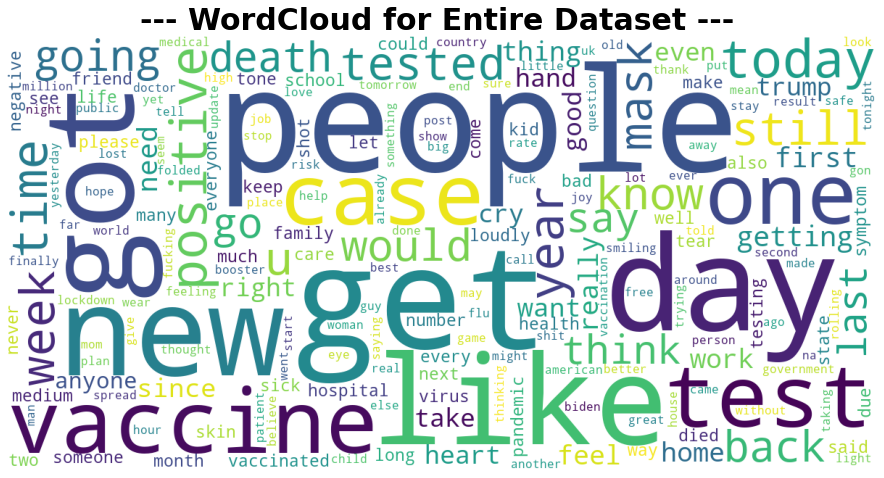

In [ ]:
source_string = " ".join(df['pr_text_swr_lemma'].astype('str'))
wordcloud(source_string,'Entire Dataset','white')

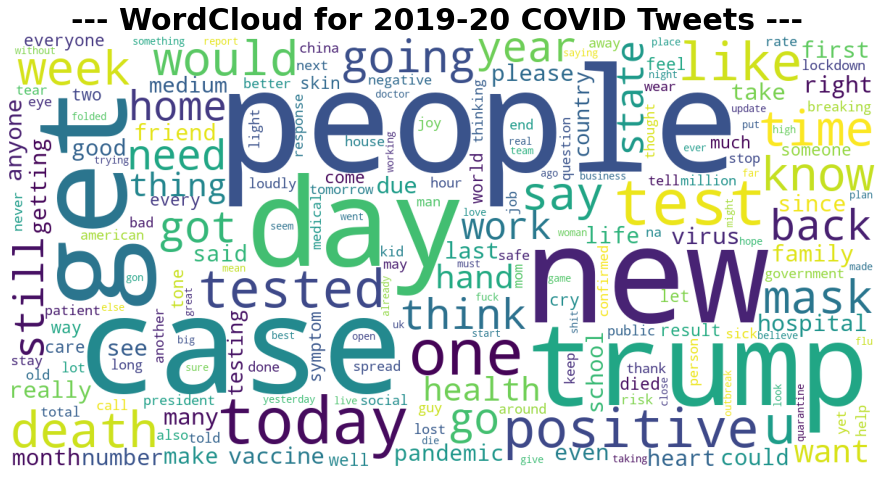

In [ ]:
source_string = " ".join(df[df.Datetime.lt(datetime.strptime('2021-01-01','%Y-%m-%d'))]['pr_text_swr_lemma'].astype('str'))
wordcloud(source_string,'2019-20 COVID Tweets','white')

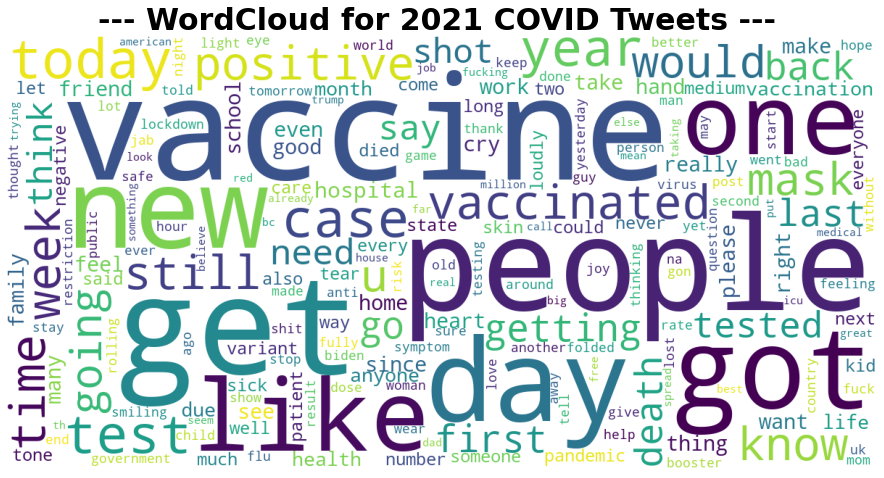

In [ ]:
source_string = " ".join(df[df.Datetime.lt(datetime.strptime('2022-01-01','%Y-%m-%d'))&df.Datetime.gt(datetime.strptime('2020-12-31','%Y-%m-%d'))]['pr_text_swr_lemma'].astype('str'))
wordcloud(source_string,'2021 COVID Tweets','white')

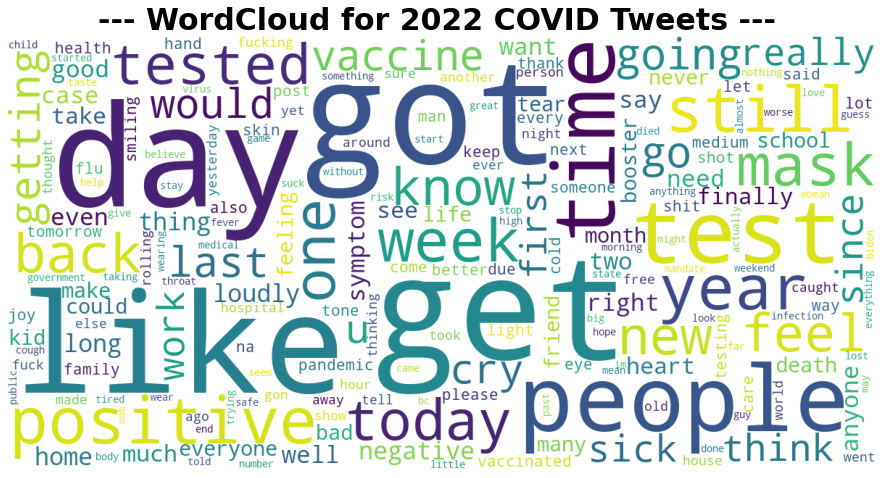

In [ ]:
source_string = " ".join(df[df.Datetime.gt(datetime.strptime('2021-12-31','%Y-%m-%d'))]['pr_text_swr_lemma'].astype('str'))
wordcloud(source_string,'2022 COVID Tweets','white')

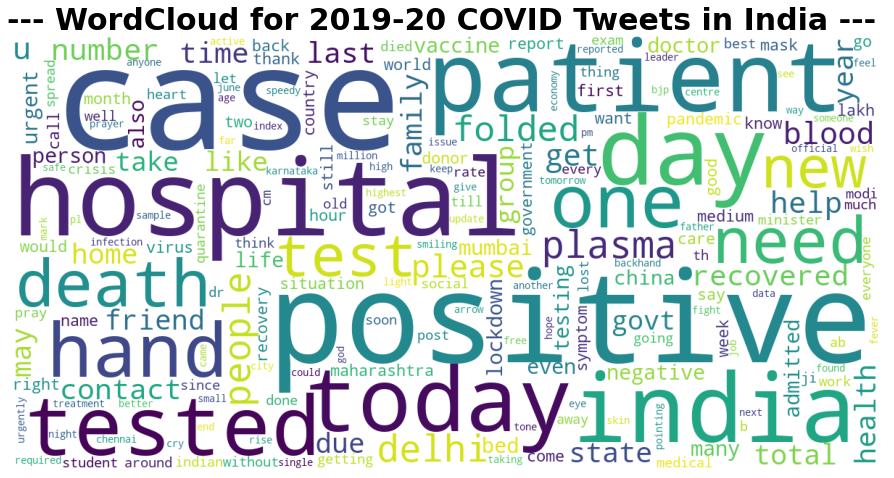

In [ ]:
source_string = " ".join(df[(df.Datetime.lt(datetime.strptime('2021-01-01','%Y-%m-%d')))&(df.country=='India')]['pr_text_swr_lemma'].astype('str'))
wordcloud(source_string,'2019-20 COVID Tweets in India','white')

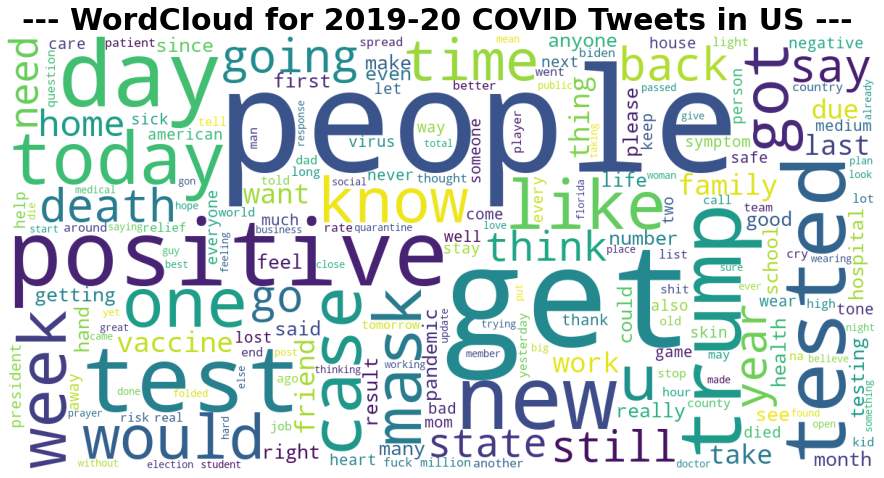

In [ ]:
source_string = " ".join(df[(df.Datetime.lt(datetime.strptime('2021-01-01','%Y-%m-%d')))&(df.country=='United States')]['pr_text_swr_lemma'].astype('str'))
wordcloud(source_string,'2019-20 COVID Tweets in US','white')

#### Comparing manual labels with OpenCISR Paper Labels

In [ ]:
df_Manual_Label = pd.read_csv('/content/drive/MyDrive/sample - sample.csv')
df_Manual_Label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Datetime           1000 non-null   object
 1   Tweet Id           1000 non-null   int64 
 2   Username           1000 non-null   object
 3   Text               1000 non-null   object
 4   pr_text            1000 non-null   object
 5   pr_text_swr        1000 non-null   object
 6   pr_text_swr_lemma  1000 non-null   object
 7   Sentiment          1000 non-null   object
dtypes: int64(1), object(7)
memory usage: 62.6+ KB


In [ ]:
df_Manual_Label

,Datetime,Tweet Id,Username,Text,pr_text,pr_text_swr,pr_text_swr_lemma,Sentiment
0,2020-03-17 23:15:24,1240054156343287808,mtlblog,is your pet helping you through self-isolation...,is your pet helping you through self-isolation...,pet helping self-isolation social distancing s...,pet helping self-isolation social distancing s...,Positive
1,2022-01-28 22:08:55,1487185948198813702,_jkuhn,only the anti vax covid is a hoax crew would g...,only the anti vax covid is a hoax crew would g...,anti vax covid hoax crew would genuinely think...,anti vax covid hoax crew would genuinely think...,Positive
2,2021-11-07 22:31:08,1457475734788886531,the_phantom40,no taste no smell it looks like covid 19,no taste no smell it looks like covid 19,taste smell looks like covid 19,taste smell look like covid 19,Neutral
3,2021-08-13 23:07:45,1426319594847936517,Rev_D_UK,f**k - my friend's grandson (not even 4) has t...,f**k - my friend's grandson (not even 4) has t...,f k friend 's grandson even 4 tested positive ...,f k friend 's grandson even 4 tested positive ...,Negative
4,2021-10-07 22:15:44,1446237833983782912,fullyvaxedak,guess how anchorage is reducing its covid numb...,guess how anchorage is reducing its covid numb...,guess anchorage reducing covid numbers reducin...,guess anchorage reducing covid number reducing...,Negative
...,...,...,...,...,...,...,...,...
995,2022-09-10 17:09:35,1568647888145891329,HuisceBeatha,five years in st. paul as of this week—and hal...,five years in st. paul as of this week—and hal...,five years st paul week—and half covid lost ti...,five year st paul week—and half covid lost tim...,Negative
996,2022-07-05 19:50:31,1544408401828057088,KarenLE67,craaaap just got a call that i and possibly mr...,craaaap just got a call that i and possibly mr...,craaaap got call possibly mr18 exposed covid c...,craaaap got call possibly mr18 exposed covid c...,Negative
997,2021-12-29 23:35:02,1476335983796924418,warrcampmusic1,aaaaand covid town,aaaaand covid town,aaaaand covid town,aaaaand covid town,Neutral
998,2020-03-29 23:11:32,1244401836485984257,Jefferson_MFG,"supermarket chain morrisons, the uk's largest ...","supermarket chain morrisons, the uk's largest ...",supermarket chain morrisons uk 's largest fres...,supermarket chain morrison uk 's largest fresh...,Positive


In [ ]:
# sentiment is OpenCISR labels and Sentiment is our manual labels
pd.merge(df_lab[df_lab.sentiment.notnull()][['Tweet Id','sentiment','text']],df_Manual_Label[['Tweet Id','Text','Sentiment']],on='Tweet Id')

,Tweet Id,sentiment,text,Text,Sentiment
0,1233483091395653632,Negative,"“the year, 2056. covid-19 has ravaged the worl...","“the year, 2056. covid-19 has ravaged the worl...",Neutral
1,1234928783024697344,Positive,so if we're not shaking hands thanks to #covid...,so if we're not shaking hands thanks to #covid...,Neutral
2,1238247654741639169,Negative,the unintended consequence of closing schools ...,the unintended consequence of closing schools ...,Negative
3,1238246375919423490,Negative,breaking: ks gov. laura kelly says a man in hi...,breaking: ks gov. laura kelly says a man in hi...,Negative
4,1239687845368877056,Negative,we've heard drive-through covid-19 test center...,we've heard drive-through covid-19 test center...,Positive
...,...,...,...,...,...
327,1528153556850819077,Negative,so i’ve noticed since i had covid my hair is f...,so i’ve noticed since i had covid my hair is f...,Negative
328,1528858658989568001,Negative,$fb down 9% ah in sympathy to $snap earnings. ...,$fb down 9% ah in sympathy to $snap earnings. ...,Neutral
329,1529579662418006016,Negative,today i submitted a story i wrote a while ago....,today i submitted a story i wrote a while ago....,Neutral
330,1530322388214501377,Negative,"life in covid land is all quite unpleasant, ev...","life in covid land is all quite unpleasant, ev...",Positive


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# sentiment is OpenCISR labels and Sentiment is our manual labels
comp = pd.merge(df_lab[df_lab.sentiment.notnull()][['Tweet Id','sentiment','text']],df_Manual_Label[['Tweet Id','Text','Sentiment']],on='Tweet Id')

In [ ]:
confusion_matrix(comp['Sentiment'], comp['sentiment'])

array([[134,  19,  19],
       [ 62,  17,  23],
       [ 17,   8,  33]])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(comp['Sentiment'],comp['sentiment']))

              precision    recall  f1-score   support

    Negative       0.63      0.78      0.70       172
     Neutral       0.39      0.17      0.23       102
    Positive       0.44      0.57      0.50        58

    accuracy                           0.55       332
   macro avg       0.49      0.50      0.48       332
weighted avg       0.52      0.55      0.52       332



In [ ]:
comp[(comp.Sentiment == 'Negative')&(comp.sentiment == 'Positive')]

,Tweet Id,sentiment,text,Text,Sentiment
10,1250545958208798720,Positive,“perhaps they knew.” —trump on china handling ...,“perhaps they knew.” —trump on china handling ...,Negative
21,1259610519255822346,Positive,how are you getting better at your craft durin...,how are you getting better at your craft durin...,Negative
27,1262517726322384897,Positive,more than 110 nations have expressed their sup...,more than 110 nations have expressed their sup...,Negative
31,1265715355592339461,Positive,ppp mpas sajid jokhio and sadia javed have bee...,ppp mpas sajid jokhio and sadia javed have bee...,Negative
41,1271163996574380033,Positive,lol the county i live in is on a watchlist for...,lol the county i live in is on a watchlist for...,Negative
45,1273712664502579209,Positive,"another day, another covid case at my apartmen...","another day, another covid case at my apartmen...",Negative
46,1274122497173204994,Positive,lmao. mississippians are trending because tate...,lmao. mississippians are trending because tate...,Negative
49,1411428412409982983,Positive,"as a reminder, ga dph is no longer updating th...","as a reminder, ga dph is no longer updating th...",Negative
71,1419401601022844937,Positive,"last spring, in the chaos of covid &amp; packi...","last spring, in the chaos of covid &amp; packi...",Negative
95,1426674668203876356,Positive,finally been on a good writing streak the last...,finally been on a good writing streak the last...,Negative


In [ ]:
comp[(comp.Sentiment == 'Positive')&(comp.sentiment == 'Negative')]

,Tweet Id,sentiment,text,Text,Sentiment
4,1239687845368877056,Negative,we've heard drive-through covid-19 test center...,we've heard drive-through covid-19 test center...,Positive
7,1246908199715946501,Negative,🏴󠁧󠁢󠁳󠁣󠁴󠁿 my own personal opinion is that loss o...,🏴󠁧󠁢󠁳󠁣󠁴󠁿 my own personal opinion is that loss o...,Positive
14,1251956022882729986,Negative,just bought an emergency plane ticket on @delt...,just bought an emergency plane ticket on @delt...,Positive
36,1268635275938476032,Negative,now that illinois is opening its state-run dri...,now that illinois is opening its state-run dri...,Positive
54,1412530321241776130,Negative,wcalgary under attack by @westjet @aircanada a...,wcalgary under attack by @westjet @aircanada a...,Positive
60,1415060680017858564,Negative,on my way to pcr covid test number one of two ...,on my way to pcr covid test number one of two ...,Positive
70,1419083547411980295,Negative,covid negative folks.,covid negative folks.,Positive
105,1433210427459227650,Negative,at this point if you're unvaccinated by choice...,at this point if you're unvaccinated by choice...,Positive
111,1435744319441342466,Negative,"maybe it's just me, but i feel like reading co...","maybe it's just me, but i feel like reading co...",Positive
132,1443716649413132293,Negative,covid chasing me around while i work normally ...,covid chasing me around while i work normally...,Positive


#### Comparing manual labels with VADER Labels

In [ ]:
# Class lables VADER 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df_Manual_Vader = data_processing(pd.read_csv('/content/drive/MyDrive/sample - sample.csv'))

In [ ]:
df_Manual_Vader.head(2)

,Datetime,Tweet Id,Username,pr_text,pr_text_swr,pr_text_swr_lemma,Sentiment,text,text_ett
0,2020-03-17 23:15:24,1240054156343287808,mtlblog,is your pet helping you through self isolation...,pet helping self isolation social distancing s...,pet helping self isolation social distancing s...,Positive,is your pet helping you through self-isolation...,is your pet helping you through self-isolation...
1,2022-01-28 22:08:55,1487185948198813702,_jkuhn,only the anti vax covid is hoax crew would gen...,anti vax hoax crew would genuinely think justi...,anti vax hoax crew would genuinely think justi...,Positive,only the anti vax covid is a hoax crew would g...,only the anti vax covid is a hoax crew would g...


In [ ]:
df_Manual_Vader['Score']= df_Manual_Vader['pr_text_swr_lemma'].apply( lambda x: SentimentIntensityAnalyzer().polarity_scores(x) )

In [ ]:
df_Manual_Vader[['text','pr_text_swr_lemma','Score']].head(6)

,text,pr_text_swr_lemma,Score
0,is your pet helping you through self-isolation...,pet helping self isolation social distancing s...,"{'neg': 0.079, 'neu': 0.706, 'pos': 0.215, 'co..."
1,only the anti vax covid is a hoax crew would g...,anti vax hoax crew would genuinely think justi...,"{'neg': 0.211, 'neu': 0.458, 'pos': 0.331, 'co..."
2,no taste no smell it looks like covid 19,taste smell look like,"{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'comp..."
3,f**k - my friend's grandson (not even 4) has t...,f k friend grandson even tested positive dad a...,"{'neg': 0.225, 'neu': 0.458, 'pos': 0.317, 'co..."
4,guess how anchorage is reducing its covid numb...,guess anchorage reducing number reducing testi...,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp..."
5,"2 shots, 1 covid, 1 booster gonna live my immu...",shot booster gon na live immunity fullest go l...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [ ]:
# Convert score to sentiment
def convert_score_to_sentiment(sentiment_dict):
  if sentiment_dict['compound'] >= 0.05 :
    return "Positive"
  elif sentiment_dict['compound'] <= - 0.05 :
    return "Negative"
  return "Neutral"
  


In [ ]:
df_Manual_Vader['VADER_sentiment'] = df_Manual_Vader.Score.apply(lambda x:convert_score_to_sentiment(x))

In [ ]:
df_Manual_Vader[0:5]

,Datetime,Tweet Id,Username,pr_text,pr_text_swr,pr_text_swr_lemma,Sentiment,text,text_ett,Score,VADER_sentiment
0,2020-03-17 23:15:24,1240054156343287808,mtlblog,is your pet helping you through self isolation...,pet helping self isolation social distancing s...,pet helping self isolation social distancing s...,Positive,is your pet helping you through self-isolation...,is your pet helping you through self-isolation...,"{'neg': 0.079, 'neu': 0.706, 'pos': 0.215, 'co...",Positive
1,2022-01-28 22:08:55,1487185948198813702,_jkuhn,only the anti vax covid is hoax crew would gen...,anti vax hoax crew would genuinely think justi...,anti vax hoax crew would genuinely think justi...,Positive,only the anti vax covid is a hoax crew would g...,only the anti vax covid is a hoax crew would g...,"{'neg': 0.211, 'neu': 0.458, 'pos': 0.331, 'co...",Positive
2,2021-11-07 22:31:08,1457475734788886531,the_phantom40,no taste no smell it looks like covid,taste smell looks like,taste smell look like,Neutral,no taste no smell it looks like covid 19,no taste no smell it looks like covid 19,"{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'comp...",Positive
3,2021-08-13 23:07:45,1426319594847936517,Rev_D_UK,f k my friend is grandson not even has tested ...,f k friend grandson even tested positive dad a...,f k friend grandson even tested positive dad a...,Negative,f**k - my friend's grandson (not even 4) has t...,f**k - my friend's grandson (not even 4) has t...,"{'neg': 0.225, 'neu': 0.458, 'pos': 0.317, 'co...",Positive
4,2021-10-07 22:15:44,1446237833983782912,fullyvaxedak,guess how anchorage is reducing its covid numb...,guess anchorage reducing numbers reducing test...,guess anchorage reducing number reducing testi...,Negative,guess how anchorage is reducing its covid numb...,guess how anchorage is reducing its covid numb...,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",Positive


Accuracy of VADER

In [ ]:
df_Manual_Vader['VADER_accuracy'] = df_Manual_Vader.apply(lambda x:x['Sentiment']==x['VADER_sentiment'],axis=1)
print("Accuracy : ",df_Manual_Vader['VADER_accuracy'].sum()*1.0/len(df_Manual_Vader))

Accuracy :  0.461


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(df_Manual_Vader['Sentiment'], df_Manual_Vader['VADER_sentiment'])

array([[285,  62, 176],
       [105,  81, 142],
       [ 34,  20,  95]])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(df_Manual_Vader['Sentiment'], df_Manual_Vader['VADER_sentiment']))

              precision    recall  f1-score   support

    Negative       0.67      0.54      0.60       523
     Neutral       0.50      0.25      0.33       328
    Positive       0.23      0.64      0.34       149

    accuracy                           0.46      1000
   macro avg       0.47      0.48      0.42      1000
weighted avg       0.55      0.46      0.47      1000



#### Comparing manual labels with Text BLOB

In [ ]:
# Lables using TextBlob
from textblob import TextBlob


In [ ]:
df_Manual_TextBlob = data_processing(pd.read_csv('/content/drive/MyDrive/sample - sample.csv'))

In [ ]:

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
  

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score > 0:
        return 'Positive'
    else:
        return 'Neutral'
 


In [ ]:
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
df_Manual_TextBlob['TextBlob_Subjectivity'] = df_Manual_TextBlob['pr_text_swr_lemma'].apply( lambda x: getSubjectivity(x))
df_Manual_TextBlob['TextBlob_Polarity'] = df_Manual_TextBlob['pr_text_swr_lemma'].apply( lambda x: getPolarity(x))
df_Manual_TextBlob['TextBlob_Analysis'] = df_Manual_TextBlob['TextBlob_Polarity'].apply(getAnalysis )

Text BLOB Accuracy

In [ ]:
df_Manual_TextBlob['TextBlob_Accuracy'] = df_Manual_TextBlob.apply(lambda x:x['Sentiment']==x['TextBlob_Analysis'],axis=1)
print("Accuracy : ",df_Manual_TextBlob['TextBlob_Accuracy'].sum()*1.0/len(df_Manual_TextBlob))

Accuracy :  0.402


In [ ]:
confusion_matrix(df_Manual_TextBlob['Sentiment'], df_Manual_TextBlob['TextBlob_Analysis'])

array([[216, 101, 206],
       [ 87,  92, 149],
       [ 28,  27,  94]])

In [ ]:
print(classification_report(df_Manual_TextBlob['Sentiment'], df_Manual_TextBlob['TextBlob_Analysis']))

              precision    recall  f1-score   support

    Negative       0.65      0.41      0.51       523
     Neutral       0.42      0.28      0.34       328
    Positive       0.21      0.63      0.31       149

    accuracy                           0.40      1000
   macro avg       0.43      0.44      0.39      1000
weighted avg       0.51      0.40      0.42      1000



In [ ]:
from nltk import word_tokenize
import re
from nltk.probability import FreqDist

In [ ]:
# most common words
tweet_text = ' '.join(x for x in df_lab.pr_text_swr_lemma.values)
fdist = FreqDist(word.lower() for word in word_tokenize(tweet_text))

[('not', 104479), ('19', 66723), ('people', 47104), ('get', 46992), ('day', 38583), ('vaccine', 37028), ('test', 33852), ('no', 33244), ('today', 32150), ('like', 31057)]


In [ ]:
print(fdist.most_common()[501:1000])

[('return', 2249), ('finger', 2244), ('treatment', 2233), ('johnson', 2232), ('canada', 2230), ('official', 2228), ('shrugging', 2227), ('throat', 2227), ('despite', 2225), ('police', 2202), ('absolutely', 2196), ('gotten', 2192), ('mouth', 2189), ('experience', 2187), ('recovery', 2185), ('hell', 2184), ('as', 2181), ('phone', 2178), ('safety', 2178), ('infected', 2172), ('blood', 2169), ('pfizer', 2160), ('saw', 2150), ('baby', 2148), ('chance', 2144), ('area', 2144), ('im', 2139), ('imagine', 2136), ('rapid', 2134), ('upside', 2131), ('mind', 2130), ('pray', 2126), ('stuff', 2122), ('national', 2119), ('alone', 2119), ('nh', 2115), ('important', 2113), ('matter', 2112), ('allowed', 2109), ('apparently', 2107), ('decision', 2101), ('closed', 2101), ('ppl', 2091), ('birthday', 2086), ('top', 2084), ('war', 2084), ('set', 2082), ('black', 2082), ('young', 2078), ('weary', 2076), ('happen', 2073), ('sent', 2068), ('increase', 2068), ('pain', 2058), ('clear', 2056), ('governor', 2053), (

<function matplotlib.pyplot.show(*args, **kw)>

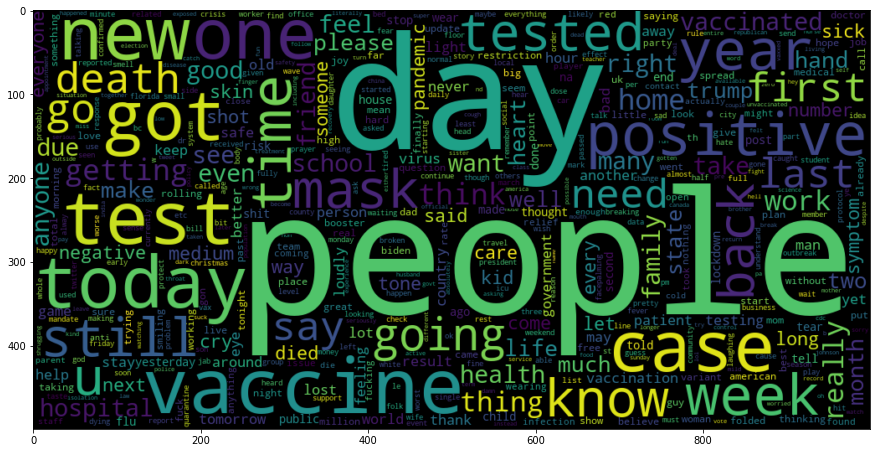

In [ ]:
plt.figure(figsize=(15,15))
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5,collocations=False)
tweet_words = WC.generate(tweet_text)
plt.imshow(tweet_words, interpolation='bilinear')
plt.show

In [ ]:
# Label Encoder for Sentiment 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_lab.sentiment)
df_lab['Sentiment_label']=le.transform(df_lab.sentiment)

In [ ]:
le.inverse_transform([0,1,2])

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
# Save the label encoder model 
filename = 'finalized_model_LabelEncoder.sav'
pickle.dump(le, open(filename, 'wb'))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Count Vectorizer 
cv1 = CountVectorizer(min_df=3, max_df=0.4, binary=False, ngram_range=(1,2), max_features=10000)
cv2 = CountVectorizer(min_df=10, max_df=0.2, binary=False, ngram_range=(1,2), max_features=4000)
cv3 = CountVectorizer(min_df=3, max_df=0.4, binary=False, ngram_range=(2,2), max_features=10000)

In [ ]:
X_train, X_test, y_train_cv, y_test_cv = train_test_split(df_lab.pr_text_swr_lemma, df_lab.Sentiment_label, test_size = 0.1, random_state =10,stratify= df_lab.Sentiment_label)
CV_X_train1 = cv1.fit_transform(X_train)
CV_X_test1 = cv1.transform(X_test)

In [ ]:
mnbcv1 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_cv1 = mnbcv1.fit(CV_X_train1, y_train_cv)
print('MultinomialNB for CV1 :', mnb_cv1)

MultinomialNB for CV1 : MultinomialNB(alpha=0.5, fit_prior=False)


In [ ]:
mnb_cv_predict1 = mnb_cv1.predict(CV_X_test1)
print('predictions for CV :', mnb_cv_predict1)

predictions for CV : [1 2 1 ... 1 0 2]


In [ ]:
mnb_cv_score = accuracy_score(y_test_cv, mnb_cv_predict1)
print("mnb_cv_score test:", mnb_cv_score)

mnb_cv_score test: 0.6466233445751419


In [ ]:
mnb_cv_predict_train = mnb_cv1.predict(CV_X_train1)
mnb_cv_score_train = accuracy_score(y_train_cv, mnb_cv_predict_train)
print("mnb_cv_score_train :", mnb_cv_score_train)

mnb_cv_score_train : 0.6629193971465913


In [ ]:
confusion_matrix(y_test_cv, mnb_cv_predict1)

array([[17381,  4404,  2514],
       [ 1571,  1717,  1330],
       [ 1243,  1826,  4485]])

In [ ]:
print(classification_report(y_test_cv, mnb_cv_predict1))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78     24299
           1       0.22      0.37      0.27      4618
           2       0.54      0.59      0.56      7554

    accuracy                           0.65     36471
   macro avg       0.54      0.56      0.54     36471
weighted avg       0.71      0.65      0.67     36471



In [ ]:
CV_X_train2 = cv2.fit_transform(X_train)
CV_X_test2 = cv2.transform(X_test)
mnbcv2 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_cv2 = mnbcv2.fit(CV_X_train2, y_train_cv)
print('MultinomialNB for CV2 :', mnb_cv2)
mnb_cv_predict2 = mnb_cv2.predict(CV_X_test2)
mnb_cv_score2 = accuracy_score(y_test_cv, mnb_cv_predict2)
print("mnb_cv2_score test:", mnb_cv_score2)
mnb_cv_predict_train2 = mnb_cv2.predict(CV_X_train2)
mnb_cv_score_train2 = accuracy_score(y_train_cv, mnb_cv_predict_train2)
print("mnb_cv2_score_train :", mnb_cv_score_train2)

MultinomialNB for CV2 : MultinomialNB(alpha=0.5, fit_prior=False)
mnb_cv2_score test: 0.6389185928545968
mnb_cv2_score_train : 0.646245571062549


In [ ]:
confusion_matrix(y_test_cv, mnb_cv_predict2)

array([[17202,  4513,  2584],
       [ 1560,  1732,  1326],
       [ 1300,  1886,  4368]])

In [ ]:
print(classification_report(y_test_cv, mnb_cv_predict2))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78     24299
           1       0.21      0.38      0.27      4618
           2       0.53      0.58      0.55      7554

    accuracy                           0.64     36471
   macro avg       0.53      0.55      0.53     36471
weighted avg       0.71      0.64      0.67     36471



In [ ]:
CV_X_train3 = cv3.fit_transform(X_train)
CV_X_test3 = cv3.transform(X_test)

In [ ]:
mnbcv3 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_cv3 = mnbcv3.fit(CV_X_train3, y_train_cv)
print('MultinomialNB for CV3 :', mnb_cv3)
mnb_cv_predict3 = mnb_cv3.predict(CV_X_test3)
mnb_cv_score3 = accuracy_score(y_test_cv, mnb_cv_predict3)
print("mnb_cv3_score test:", mnb_cv_score3)
mnb_cv_predict_train3 = mnb_cv3.predict(CV_X_train3)
mnb_cv_score_train3 = accuracy_score(y_train_cv, mnb_cv_predict_train3)
print("mnb_cv3_score_train :", mnb_cv_score_train3)

MultinomialNB for CV3 : MultinomialNB(alpha=0.5, fit_prior=False)
mnb_cv3_score test: 0.5945819966548764
mnb_cv3_score_train : 0.6193444410932278


In [ ]:
cv4 = CountVectorizer(min_df=3, max_df=0.4, binary=False, ngram_range=(1,3), max_features=10000)
CV_X_train4 = cv4.fit_transform(X_train)
CV_X_test4 = cv4.transform(X_test)

In [ ]:
mnbcv4 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_cv4 = mnbcv4.fit(CV_X_train4, y_train_cv)
print('MultinomialNB for CV4 :', mnb_cv4)
mnb_cv_predict4 = mnb_cv4.predict(CV_X_test4)
mnb_cv_score4 = accuracy_score(y_test_cv, mnb_cv_predict4)
print("mnb_cv4_score test:", mnb_cv_score4)
mnb_cv_predict_train4 = mnb_cv4.predict(CV_X_train4)
mnb_cv_score_train4 = accuracy_score(y_train_cv, mnb_cv_predict_train4)
print("mnb_cv4_score_train :", mnb_cv_score_train4)

MultinomialNB for CV4 : MultinomialNB(alpha=0.5, fit_prior=False)
mnb_cv4_score test: 0.6516410298593402
mnb_cv4_score_train : 0.6680041067636692


In [ ]:
print(classification_report(y_test_cv, mnb_cv4.predict(CV_X_test4)))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79     24299
           1       0.22      0.36      0.27      4618
           2       0.54      0.58      0.56      7554

    accuracy                           0.65     36471
   macro avg       0.54      0.56      0.54     36471
weighted avg       0.71      0.65      0.67     36471



In [ ]:
cv5 = CountVectorizer(min_df=3, max_df=0.4, binary=True, ngram_range=(1,2), max_features=10000)
CV_X_train5 = cv5.fit_transform(X_train)
CV_X_test5 = cv5.transform(X_test)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(fit_prior=False)
bnb_5 = bnb.fit(CV_X_train5, y_train_cv)
print('BernoulliNB for CV5 :', bnb_5)
bnb_predict5 = bnb_5.predict(CV_X_test5)
bnb_score5 = accuracy_score(y_test_cv, bnb_predict5)
print("bnb_score test:", bnb_score5)
bnb_predict_train5 = bnb_5.predict(CV_X_train5)
bnb_score_train5 = accuracy_score(y_train_cv, bnb_predict_train5)
print("bnb_score_train :", bnb_score_train5)

BernoulliNB for CV5 : BernoulliNB(fit_prior=False)
bnb_score test: 0.6364782978256697
bnb_score_train : 0.651025624621084


In [ ]:
print(classification_report(y_test_cv, bnb_5.predict(CV_X_test5)))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77     24299
           1       0.21      0.39      0.28      4618
           2       0.53      0.61      0.56      7554

    accuracy                           0.64     36471
   macro avg       0.54      0.56      0.54     36471
weighted avg       0.72      0.64      0.67     36471



In [ ]:
# TF-IDF Vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
tv1 = TfidfVectorizer(min_df=3, max_df=0.4, use_idf=True, ngram_range=(1,2),max_features = 10000)
tv1

TfidfVectorizer(max_df=0.4, max_features=10000, min_df=3, ngram_range=(1, 2))

In [ ]:
X_train, X_test, y_train_tv, y_test_tv = train_test_split(df_lab.pr_text_swr_lemma, df_lab.Sentiment_label, test_size = 0.05, random_state =12,stratify= df_lab.Sentiment_label)

In [ ]:
tfidf1_X_train = tv1.fit_transform(X_train)
tfidf1_X_test = tv1.transform(X_test)

In [ ]:
mnb_tv1 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_tfidf1 = mnb_tv1.fit(tfidf1_X_train, y_train_tv)
print('MultinomialNB for tf-idf :', mnb_tfidf1)
mnb_tfidf1_predict = mnb_tfidf1.predict(tfidf1_X_test)
mnb_tfidf1_score = accuracy_score(y_test_tv, mnb_tfidf1_predict)
print("mnb_tfidf1_score :", mnb_tfidf1_score)
mnb_tfidf1_predict_train = mnb_tfidf1.predict(tfidf1_X_train)
mnb_tfidf1_score_train = accuracy_score(y_train_tv, mnb_tfidf1_predict_train)
print("mnb_tfidf_score_train :", mnb_tfidf1_score_train)

MultinomialNB for tf-idf : MultinomialNB(alpha=0.5, fit_prior=False)
mnb_tfidf1_score : 0.6420267602544417
mnb_tfidf_score_train : 0.6572758706280991


In [ ]:
confusion_matrix(y_test_tv, mnb_tfidf1_predict)

array([[8434, 2429, 1287],
       [ 674,  984,  651],
       [ 525,  962, 2290]])

In [ ]:
print(classification_report(y_test_tv, mnb_tfidf1_predict))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77     12150
           1       0.22      0.43      0.29      2309
           2       0.54      0.61      0.57      3777

    accuracy                           0.64     18236
   macro avg       0.55      0.58      0.55     18236
weighted avg       0.72      0.64      0.67     18236



In [ ]:
tv2 = TfidfVectorizer(min_df=25, max_df=0.06, use_idf=True, ngram_range=(1,3),max_features = 10000)
tv2
tfidf2_X_train = tv2.fit_transform(X_train)
tfidf2_X_test = tv2.transform(X_test)

In [ ]:
mnb_tv2 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_tfidf2 = mnb_tv2.fit(tfidf2_X_train, y_train_tv)
print('MultinomialNB for tf-idf :', mnb_tfidf2)
mnb_tfidf2_predict = mnb_tfidf2.predict(tfidf2_X_test)
mnb_tfidf2_score = accuracy_score(y_test_tv, mnb_tfidf2_predict)
print("mnb_tfidf2_score :", mnb_tfidf2_score)
mnb_tfidf2_predict_train = mnb_tfidf2.predict(tfidf2_X_train)
mnb_tfidf2_score_train = accuracy_score(y_train_tv, mnb_tfidf2_predict_train)
print("mnb_tfidf_score_train :", mnb_tfidf2_score_train)

MultinomialNB for tf-idf : MultinomialNB(alpha=0.5, fit_prior=False)
mnb_tfidf2_score : 0.6425202895371792
mnb_tfidf_score_train : 0.6587478425509562


In [ ]:
confusion_matrix(y_test_tv, mnb_tfidf2_predict)

array([[8497, 2397, 1256],
       [ 692,  978,  639],
       [ 561,  974, 2242]])

In [ ]:
print(classification_report(y_test_tv, mnb_tfidf2_predict))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78     12150
           1       0.22      0.42      0.29      2309
           2       0.54      0.59      0.57      3777

    accuracy                           0.64     18236
   macro avg       0.55      0.57      0.55     18236
weighted avg       0.72      0.64      0.67     18236



In [ ]:
tv3 = TfidfVectorizer(min_df=25, max_df=0.06, use_idf=True, ngram_range=(1,2),max_features = 2000)
tv3
tfidf3_X_train = tv3.fit_transform(X_train)
tfidf3_X_test = tv3.transform(X_test)

In [ ]:
mnb_tv3 = MultinomialNB(alpha=0.5,fit_prior=False)
mnb_tfidf3 = mnb_tv3.fit(tfidf3_X_train, y_train_tv)
print('MultinomialNB for tf-idf :', mnb_tfidf3)
mnb_tfidf3_predict = mnb_tfidf3.predict(tfidf3_X_test)
mnb_tfidf3_score = accuracy_score(y_test_tv, mnb_tfidf3_predict)
print("mnb_tfidf2_score :", mnb_tfidf3_score)
mnb_tfidf3_predict_train = mnb_tfidf3.predict(tfidf3_X_train)
mnb_tfidf3_score_train = accuracy_score(y_train_tv, mnb_tfidf3_predict_train)
print("mnb_tfidf_score_train :", mnb_tfidf3_score_train)

MultinomialNB for tf-idf : MultinomialNB(alpha=0.5, fit_prior=False)
mnb_tfidf2_score : 0.6152665058126782
mnb_tfidf_score_train : 0.6245519144293655


In [ ]:
confusion_matrix(y_test_tv, mnb_tfidf3_predict)

array([[8116, 2635, 1399],
       [ 733,  938,  638],
       [ 611, 1000, 2166]])

In [ ]:
print(classification_report(y_test_tv, mnb_tfidf3_predict))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75     12150
           1       0.21      0.41      0.27      2309
           2       0.52      0.57      0.54      3777

    accuracy                           0.62     18236
   macro avg       0.53      0.55      0.52     18236
weighted avg       0.70      0.62      0.65     18236



In [ ]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_tv = RandomForestClassifier(n_estimators=50, random_state=123, max_features=5, criterion="entropy", min_samples_split=100, max_depth=100)
rf_tv.fit(tfidf1_X_train, y_train_tv)
test_acc = accuracy_score(y_test_tv, rf_tv.predict(tfidf1_X_test))
print("Test accuracy for RF: ", test_acc)

Test accuracy for RF:  0.6668128975652555


In [ ]:
train_acc = accuracy_score(y_train_tv, rf_tv.predict(tfidf1_X_train))
print("train accuracy for RF: ", train_acc)

train accuracy for RF:  0.6668610054434099


In [ ]:
confusion_matrix(y_test_tv, rf_tv.predict(tfidf1_X_test))

array([[12150,     0,     0],
       [ 2307,     1,     1],
       [ 3768,     0,     9]])

In [ ]:
print(classification_report(y_test_tv, rf_tv.predict(tfidf1_X_test)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     12150
           1       1.00      0.00      0.00      2309
           2       0.90      0.00      0.00      3777

    accuracy                           0.67     18236
   macro avg       0.86      0.33      0.27     18236
weighted avg       0.76      0.67      0.53     18236



In [ ]:
rf_cv = RandomForestClassifier(n_estimators=50, random_state=123, max_depth=20)
rf_cv.fit(CV_X_train1, y_train_cv)
test_acc = accuracy_score(y_test_cv, rf_cv.predict(CV_X_test1))
print("Test accuracy for RF: ", test_acc)

Test accuracy for RF:  0.6688418512831761


In [ ]:
train_acc = accuracy_score(y_train_cv, rf_cv.predict(CV_X_train1))
print("train accuracy for RF: ", train_acc)

train accuracy for RF:  0.669273884909113


In [ ]:
confusion_matrix(y_test_cv, rf_cv.predict(CV_X_test1))

array([[12149,     0,     1],
       [ 2305,     0,     4],
       [ 3729,     0,    48]])

In [ ]:
print(classification_report(y_test_cv,rf_cv.predict(CV_X_test1)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     12150
           1       0.00      0.00      0.00      2309
           2       0.91      0.01      0.03      3777

    accuracy                           0.67     18236
   macro avg       0.52      0.34      0.28     18236
weighted avg       0.63      0.67      0.54     18236



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rf_cv.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#xgboost

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

In [ ]:
xgb_cl = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100, gamma=0.5, subsample=0.7, scale_pos_weight=5)

In [ ]:
xgb_cl.fit(tfidf1_X_train, y_train_tv)
test_acc = accuracy_score(y_test_tv, xgb_cl.predict(tfidf1_X_test))
print("Test accuracy for XGboost: ", test_acc)

Test accuracy for XGboost:  0.6903926299627111


In [ ]:
Train_acc = accuracy_score(y_train_tv, xgb_cl.predict(tfidf1_X_train))
print("train accuracy for XGboost: ", train_acc)

train accuracy for XGboost:  0.669273884909113


In [ ]:
confusion_matrix(y_test_tv, xgb_cl.predict(tfidf1_X_test))

array([[12054,     1,    95],
       [ 2254,     1,    54],
       [ 3240,     2,   535]])

In [ ]:
print(classification_report(y_test_tv,xgb_cl.predict(tfidf1_X_test)))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81     12150
           1       0.25      0.00      0.00      2309
           2       0.78      0.14      0.24      3777

    accuracy                           0.69     18236
   macro avg       0.57      0.38      0.35     18236
weighted avg       0.65      0.69      0.59     18236



In [ ]:
xgb_cl_cv = xgb.XGBClassifier()
xgb_cl_cv.fit(CV_X_train1, y_train_cv)
test_acc = accuracy_score(y_test_cv, xgb_cl_cv.predict(CV_X_test1))
print("Test accuracy for XGboost: ", test_acc)
Train_acc = accuracy_score(y_train_cv, xgb_cl_cv.predict(CV_X_train1))
print("train accuracy for XGboost: ", train_acc)

Test accuracy for XGboost:  0.6890765518754113
train accuracy for XGboost:  0.669273884909113


In [ ]:
confusion_matrix(y_test_tv, xgb_cl_cv.predict(tfidf1_X_test))

array([[12051,     1,    98],
       [ 2252,     1,    56],
       [ 3259,     1,   517]])

In [ ]:
print(classification_report(y_test_tv,xgb_cl_cv.predict(tfidf1_X_test)))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81     12150
           1       0.33      0.00      0.00      2309
           2       0.77      0.14      0.23      3777

    accuracy                           0.69     18236
   macro avg       0.60      0.38      0.35     18236
weighted avg       0.66      0.69      0.59     18236



In [ ]:
filename = 'finalized_model_mnb_08.sav'
pickle.dump(mnb_cv1, open(filename, 'wb'))

In [ ]:
filename = 'finalized_model_cv1_08.sav'
pickle.dump(cv1, open(filename, 'wb'))

# NN model training 

In [ ]:
cv_tensor = CountVectorizer(min_df=10, max_df=0.4, binary=False, ngram_range=(1,2), max_features=5000)

In [ ]:
X_train, X_test, y_train_cv, y_test_cv = train_test_split(df_lab.pr_text_swr_lemma,  to_categorical(df_lab.Sentiment_label), test_size = 0.1, random_state =12,stratify= df_lab.Sentiment_label)
CV_X_train1 = cv_tensor.fit_transform(X_train)
CV_X_test1 = cv_tensor.transform(X_test)

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
def convert_sparse_matrix_to_tensor(X):
    return tf.convert_to_tensor(X.toarray())

In [ ]:
CV_X_train_tensor=convert_sparse_matrix_to_tensor(CV_X_train1)
CV_X_test_tensor= convert_sparse_matrix_to_tensor(CV_X_test1)

In [ ]:
y_train_cv_tensor=tf.convert_to_tensor(y_train_cv)
y_test_cv_tensor=tf.convert_to_tensor(y_test_cv)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


In [ ]:
model=Sequential() 
model.add(Dense(500,activation='relu')) 
model.add(Dense(50,activation='relu')) 
model.add(Dense(3,activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"]) 
history = model.fit(CV_X_train_tensor,y_train_cv_tensor, validation_split=0.1, epochs=10, verbose=1, callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
9232/9232 [==============================] - 31s 3ms/step - loss: 0.6410 - accuracy: 0.7479 - val_loss: 0.6144 - val_accuracy: 0.7596
Epoch 2/10
9232/9232 [==============================] - 26s 3ms/step - loss: 0.5815 - accuracy: 0.7702 - val_loss: 0.6058 - val_accuracy: 0.7663
Epoch 3/10
9232/9232 [==============================] - 26s 3ms/step - loss: 0.5445 - accuracy: 0.7840 - val_loss: 0.6062 - val_accuracy: 0.7642
Epoch 4/10
9232/9232 [==============================] - 27s 3ms/step - loss: 0.4975 - accuracy: 0.8007 - val_loss: 0.6289 - val_accuracy: 0.7596


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               2500500   
                                                                 
 dense_1 (Dense)             (None, 50)                25050     
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 2,525,703
Trainable params: 2,525,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filename = 'finalized_model_cv_tensor.sav'
pickle.dump(cv_tensor, open(filename, 'wb'))

In [ ]:
print(classification_report(np.argmax(y_test_cv_tensor,axis=1) ,np.argmax(model.predict(CV_X_test_tensor), axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     24299
           1       0.31      0.11      0.16      4618
           2       0.64      0.62      0.63      7554

    accuracy                           0.75     36471
   macro avg       0.59      0.55      0.55     36471
weighted avg       0.71      0.75      0.72     36471



In [ ]:
print(classification_report(np.argmax(y_train_cv_tensor,axis=1) ,np.argmax(model.predict(CV_X_train_tensor), axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91    218691
           1       0.67      0.26      0.38     41562
           2       0.78      0.77      0.78     67986

    accuracy                           0.83    328239
   macro avg       0.77      0.67      0.69    328239
weighted avg       0.82      0.83      0.81    328239



In [ ]:
confusion_matrix(np.argmax(y_test_cv_tensor,axis=1) ,np.argmax(model.predict(CV_X_test_tensor), axis=1))

array([[22250,   607,  1442],
       [ 2900,   498,  1220],
       [ 2351,   493,  4710]])

In [ ]:
model.save("Basic_NN_Model2.h5")

In [ ]:
reconstructed_model=tf.keras.models.load_model ("/content/drive/MyDrive/Basic_NN_Model2.h5")